Blog: [Navigating with grid-like representations in artificial agents](https://deepmind.com/blog/article/grid-cells)

Paper: [EMERGENCE OF GRID-LIKE REPRESENTATIONS BY
TRAINING RECURRENT NEURAL NETWORKS TO
PERFORM SPATIAL LOCALIZATION](https://openreview.net/pdf?id=B17JTOe0-
)

\\
References: \\
[A unified theory for the origin of grid cells through
the lens of pattern formation](https://papers.nips.cc/paper/9191-a-unified-theory-for-the-origin-of-grid-cells-through-the-lens-of-pattern-formation.pdf)

In [ ]:
!pip3 install torch torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

**Data Generation**

10000 paths, each with 500 steps starting at (0,0) in field of 40x40

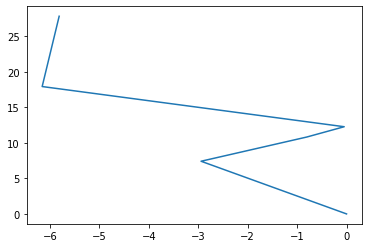

In [3]:
def generate_input(path):
  
  input = []
  state = [0, 0]  
  for next_state in path:
    delta_y = next_state[1]-state[1]
    delta_x = next_state[0]-state[0]
    speed = ((delta_y)**2 + (delta_x)**2)**0.5
    direction = np.arctan2(delta_y,delta_x)
    input.append([speed,direction])
    state = next_state
  
  return input

N = 10000 # Number of data samples
split = 0.8 # Train-Test split

input_set = []
output_set = []

for i in range(N):

  path = []
  steps = 5
  for x in range(steps): 
    delta = list(np.random.uniform(-10,10,2))
    if x==0: path.append(delta)
    else: path.append([max(min(path[x-1][0]+delta[0],100),-100),max(min(path[x-1][1]+delta[1],100),-100)])

  input = generate_input(path)
  
  input_set.append(input)
  output_set.append(path)

plt.plot([0]+[state[0] for state in output_set[0]], [0]+[state[1] for state in output_set[0]])
plt.show()


**Final Model**

In [11]:
M = 1

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.RNNCell(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size, False)
        # self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(hidden)
        # output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(M, self.hidden_size)

rnn = RNN(2, 100, 2)


**Setup**

In [12]:
learning_rate = 0.01
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(rnn.parameters(), lr=0.1, momentum=0.9)

def train(path_tensor, instruction_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    # optimizer.zero_grad()

    estimate_tensor = torch.zeros(path_tensor.size()[0], M, 2)

    for i in range(instruction_tensor.size()[0]):
        estimate_tensor[i], hidden = rnn(instruction_tensor[i], hidden)
        
    loss = criterion(estimate_tensor, path_tensor)
    loss.backward()
    

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    # optimizer.step()

    return estimate_tensor, loss.item()

def test(instruction_tensor):
    hidden = rnn.initHidden()

    path = []
    for i in range(instruction_tensor.size()[0]):
        output, hidden = rnn(instruction_tensor[i], hidden)
        path.append(output.tolist()[0])

    return path

def toTensor(path):
  tensor = torch.zeros(len(path), 1, 2)
  for li, step in enumerate(path):
      tensor[li][0][0] = step[0]
      tensor[li][0][1] = step[1]
  return tensor


**Training**

In [15]:
epochs = 10
for e in range(epochs):
  print(f'epoch: {e}')

  for iter in range(int(split*N)):
    # print(iter)
    
    # instruction = input_set[iter*M]
    # path = output_set[iter*M]
    instruction = input_set[iter]
    path = output_set[iter]
    path_tensor = toTensor(path)
    instruction_tensor = toTensor(instruction)
    
    # for i in range(1,M):
    #   instruction = input_set[iter*M+i]
    #   path = output_set[iter*M+i]
    #   path_tensor = torch.cat((path_tensor, toTensor(path)), 1)
    #   instruction_tensor = torch.cat((instruction_tensor, toTensor(instruction)), 1)
    output, loss = train(path_tensor, instruction_tensor)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


**Testing**

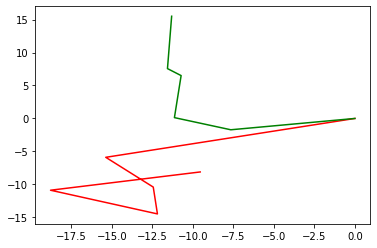

tensor(158.4821)


In [16]:
instruction = input_set[int(split*N)]
actual_path = output_set[int(split*N)]
intruction_tensor = toTensor(instruction)
estimated_path = test(instruction_tensor)

plt.plot([0]+[state[0] for state in estimated_path], [0]+[state[1] for state in estimated_path], 'r')
plt.plot([0]+[state[0] for state in actual_path], [0]+[state[1] for state in actual_path], 'g')
plt.show()
print(criterion(toTensor(estimated_path), toTensor(actual_path)))

In [9]:
for p in rnn.parameters():
  print(p.data)

tensor([[ 0.0206, -0.5614,  0.0848,  ...,  0.0842, -0.0327,  0.0398],
        [ 0.0573, -0.4528,  0.0386,  ..., -0.0075,  0.0852,  0.1321],
        [ 0.0963, -0.5799,  0.0338,  ..., -0.0257,  0.0809, -0.1045],
        ...,
        [-0.0934,  0.8415,  0.1482,  ...,  0.0950, -0.1569, -0.1039],
        [ 0.2181,  0.0080,  0.2927,  ..., -0.2811,  0.3383, -0.1323],
        [ 0.0271,  0.6085,  0.0555,  ..., -0.1815, -0.1769, -0.1795]])
tensor([[-0.0228,  0.0529,  0.0744,  ...,  0.0464,  0.0629, -0.0176],
        [ 0.0965, -0.0427,  0.0187,  ..., -0.0143,  0.0714, -0.0289],
        [ 0.0619,  0.0215,  0.0988,  ...,  0.0814,  0.0816,  0.0759],
        ...,
        [-0.0156, -0.0139, -0.0180,  ...,  0.0909, -0.0807,  0.0795],
        [-0.0219,  0.0729,  0.0737,  ..., -0.0859,  0.0627,  0.0456],
        [ 0.0085,  0.0204, -0.0821,  ...,  0.0896,  0.0391,  0.0292]])
tensor([-0.0867, -0.3484, -0.1004, -0.0785, -0.0401,  0.1931,  0.0785, -0.1155,
        -0.1196, -0.5537,  0.1969,  0.1463, -0.5802,

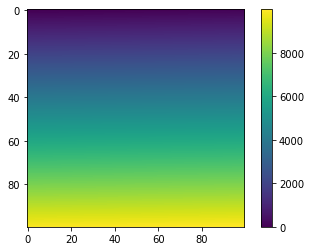

In [17]:
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()


test_array = np.arange(100 * 100).reshape(100, 100)
heatmap2d(test_array)